# NYC Taxi Data: Tree Regression Modeling

This notebook focuses on building and evaluating advanced regression models, including Random Forest and Gradient Boosting, on the NYC taxi dataset. We aim to predict taxi fare amounts using a variety of features and evaluate model performance using key metrics like RMSE, MAE, and R-squared.

## Libraries and Initial Setup

We start by importing the necessary libraries, initializing a Spark session, and loading the preprocessed dataset.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import expm1
from pyspark.sql.functions import col, to_date
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

import scipy.stats as stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Initialize Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)  # Enable eager evaluation for interactive querying
    .config("spark.sql.parquet.cacheMetadata", "true")  # Cache metadata for parquet files
    .config("spark.sql.session.timeZone", "Etc/UTC")  # Set the timezone to UTC
    .getOrCreate()  # Create or retrieve the existing Spark session
)

24/08/25 20:46:03 WARN Utils: Your hostname, apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.11.182 instead (on interface en0)
24/08/25 20:46:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 20:46:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data

We load the preprocessed data from a Parquet file into a Spark DataFrame for modeling.

In [3]:
# Load the preprocessed data from a Parquet file
df_train = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development')

### Set Up Evaluators

We set up evaluators to assess the performance of our models using metrics such as RMSE, MAE, and R-squared.

In [4]:
# Define evaluators for RMSE, MAE, and R-squared
rmse_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='mae')
r2_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')

### Data Preparation

We prepare the dataset by dropping unnecessary columns (e.g., datetime columns) and split the data into training and test sets based on the `days_since_2022_11_01` feature.

In [5]:
# Drop datetime columns that are not needed for modeling
df_train = df_train.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')

In [6]:
# df_train.columns

In [7]:
# Define the relevant columns to include in the model
relevant_columns = ['VendorID',
                    'trip_distance',
                    'RatecodeID',
                    'PULocationID',
                    'DOLocationID',
                    'extra',
                    'mta_tax',
                    'tolls_amount',
                    'improvement_surcharge',
                    'congestion_surcharge',
                    'airport_fee',
                    'trip_duration_mins',
                    'pickup_hour',
                    'pickup_dayofweek',
                    'dropoff_hour',
                    'dropoff_dayofweek',
                    'days_since_2022_11_01',
                    'distance_time_interaction',
                    'is_airport_trip',
                    'is_tourist_trip',
                    'pickup_at_airport',
                    'dropoff_at_airport',
                    'pickup_at_tourist_attraction',
                    'dropoff_at_tourist_attraction',
                    'is_holiday_season',
                    'is_event_day',
                    'avg_temp',
                    ]

# Split the data into training and test sets
train_end_date = '2023-03-31'
test_start_date = '2023-04-01'

train_data = df_train.filter(
    (to_date(col('tpep_pickup_datetime')) >= '2022-11-01') & 
    (to_date(col('tpep_pickup_datetime')) <= train_end_date)
)

test_data = df_train.filter(
    (to_date(col('tpep_pickup_datetime')) >= test_start_date) & 
    (to_date(col('tpep_pickup_datetime')) <= '2023-04-30')
)

## Feature Assembly and Scaling

We use `VectorAssembler` to combine the relevant columns into a single feature vector and then apply `StandardScaler` to standardize the features.

In [8]:
# Assemble the relevant features into a single feature vector
fare_assembler = VectorAssembler(inputCols=relevant_columns, outputCol='unscaled_features')
fare_train_assembled = fare_assembler.transform(train_data)
fare_test_assembled = fare_assembler.transform(test_data)

In [9]:
# Apply standard scaling to the feature vector
fare_scaler = StandardScaler(inputCol='unscaled_features', outputCol='scaled_features')
fare_scaler_model = fare_scaler.fit(fare_train_assembled)

24/08/25 20:46:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
fare_train_scaled = fare_scaler_model.transform(fare_train_assembled).select('scaled_features', 'fare_amount')
fare_test_scaled = fare_scaler_model.transform(fare_test_assembled).select('scaled_features', 'fare_amount')

## Random Forest Regression

We build a Random Forest regression model using the scaled features, train the model on the training set, and evaluate its performance on the test set. The hyperparameters were tuned manually instead of using paramBuilder (running out of memory, crash while fitting models,...).

In [11]:
# Train a Random Forest regression model on the scaled features
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='fare_amount', seed=1003, numTrees=40)
rf_model = rf.fit(fare_train_scaled)

24/08/25 20:47:31 WARN MemoryStore: Not enough space to cache rdd_26_2 in memory! (computed 66.3 MiB so far)
24/08/25 20:47:31 WARN BlockManager: Persisting block rdd_26_2 to disk instead.
24/08/25 20:47:33 WARN MemoryStore: Not enough space to cache rdd_26_0 in memory! (computed 103.2 MiB so far)
24/08/25 20:47:33 WARN BlockManager: Persisting block rdd_26_0 to disk instead.
24/08/25 20:47:33 WARN MemoryStore: Not enough space to cache rdd_26_1 in memory! (computed 103.2 MiB so far)
24/08/25 20:47:33 WARN BlockManager: Persisting block rdd_26_1 to disk instead.
24/08/25 20:47:51 WARN MemoryStore: Not enough space to cache rdd_26_2 in memory! (computed 44.0 MiB so far)
24/08/25 20:47:51 WARN MemoryStore: Not enough space to cache rdd_26_1 in memory! (computed 66.3 MiB so far)
24/08/25 20:47:56 WARN MemoryStore: Not enough space to cache rdd_26_0 in memory! (computed 66.3 MiB so far)
24/08/25 20:47:59 WARN MemoryStore: Not enough space to cache rdd_26_4 in memory! (computed 44.0 MiB so 

In [12]:
# Save the trained Random Forest model
rf_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/rf_model")

In [13]:
# Evaluate the model on the test set and print the performance metrics
rf_predictions = rf_model.transform(fare_test_scaled)

rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
print(f"Random Forest Regressor on test_data - RMSE: {rf_rmse}, MAE: {rf_mae}, R2: {rf_r2}")

Random Forest Regressor on test_data - RMSE: 7.9740705003868815, MAE: 4.653359316869933, R2: 0.7481371814625692


### Residuals Analysis for Random Forest

We analyze the residuals of the Random Forest model by plotting the residuals against the predictions, examining the distribution of residuals, and creating a Q-Q plot to check for normality.

In [14]:
# Calculate residuals for the Random Forest model
rf_residuals = rf_predictions.select('fare_amount', 'prediction', (rf_predictions['fare_amount'] - rf_predictions['prediction']).alias('residuals'))

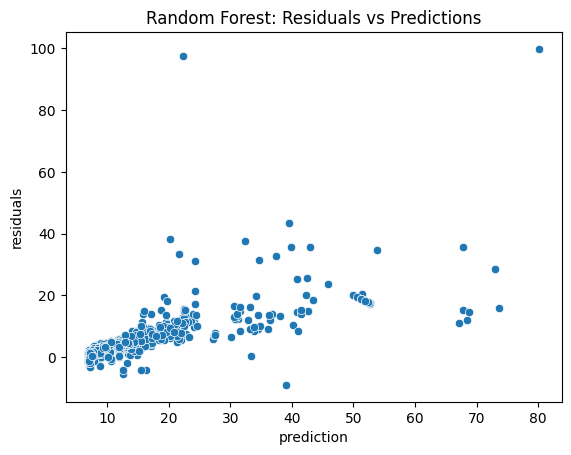

In [15]:
# Convert the residuals to a Pandas DataFrame for visualization
rf_residuals_pandas = rf_residuals.toPandas()

# Plot residuals vs predictions for the Random Forest model
sns.scatterplot(x=rf_residuals_pandas['prediction'], y=rf_residuals_pandas['residuals'])
plt.title("Random Forest: Residuals vs Predictions")
plt.show()

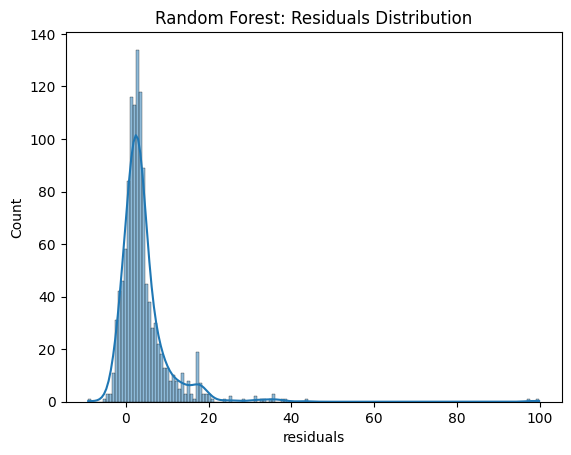

In [16]:
# Plot histogram of residuals for the Random Forest model
sns.histplot(rf_residuals_pandas['residuals'], kde=True)
plt.title("Random Forest: Residuals Distribution")
plt.show()

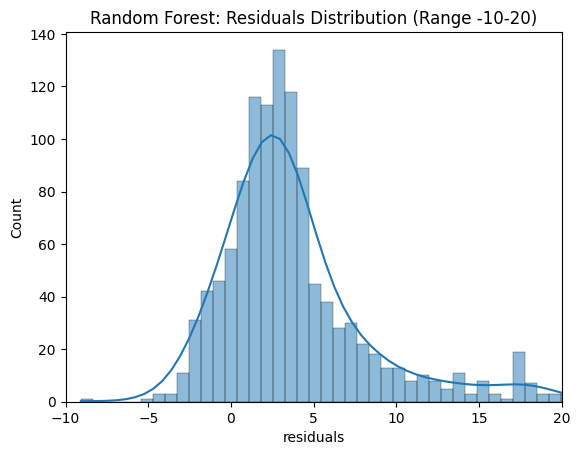

In [19]:
sns.histplot(rf_residuals_pandas['residuals'], kde=True)
plt.title("Random Forest: Residuals Distribution (Range -10-20)")
plt.xlim(-10, 20)
plt.show()

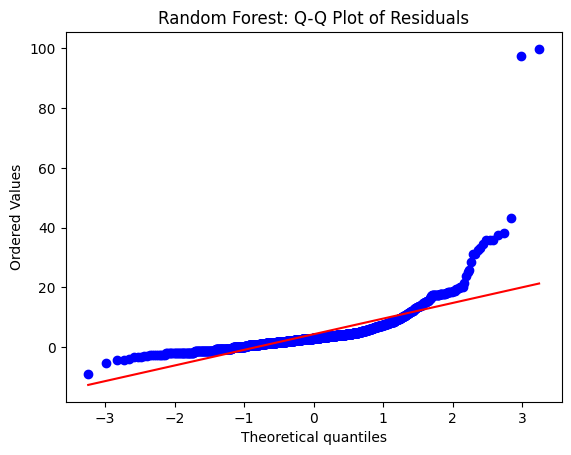

In [20]:
# Q-Q plot of residuals for the Random Forest model to check normality
stats.probplot(rf_residuals_pandas['residuals'], dist="norm", plot=plt)
plt.title("Random Forest: Q-Q Plot of Residuals")
plt.show()

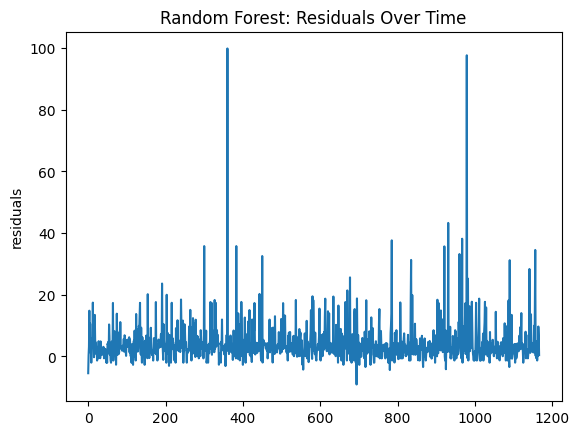

In [21]:
# Plot residuals over time for the Random Forest model
sns.lineplot(x=range(len(rf_residuals_pandas['residuals'])), y=rf_residuals_pandas['residuals'])
plt.title("Random Forest: Residuals Over Time")
plt.show()

### Feature Importance in Random Forest

We extract and print the feature importances from the trained Random Forest model to understand which features have the most impact on predicting fare amounts.

In [34]:
# Extract and print feature importances from the Random Forest model
feature_importances = rf_model.featureImportances
feature_names = relevant_columns
feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}

print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature Importances:
Feature: VendorID, Importance: 0.0000
Feature: trip_distance, Importance: 0.4469
Feature: RatecodeID, Importance: 0.0868
Feature: PULocationID, Importance: 0.0018
Feature: DOLocationID, Importance: 0.0057
Feature: extra, Importance: 0.0005
Feature: mta_tax, Importance: 0.0131
Feature: tolls_amount, Importance: 0.0443
Feature: improvement_surcharge, Importance: 0.0000
Feature: congestion_surcharge, Importance: 0.0009
Feature: airport_fee, Importance: 0.0102
Feature: trip_duration_mins, Importance: 0.1464
Feature: pickup_hour, Importance: 0.0022
Feature: pickup_dayofweek, Importance: 0.0000
Feature: dropoff_hour, Importance: 0.0011
Feature: dropoff_dayofweek, Importance: 0.0000
Feature: days_since_2022_11_01, Importance: 0.0000
Feature: distance_time_interaction, Importance: 0.1635
Feature: is_airport_trip, Importance: 0.0575
Feature: is_tourist_trip, Importance: 0.0000
Feature: pickup_at_airport, Importance: 0.0125
Feature: dropoff_at_airport, Importance: 0.0065
Fea

#### 1. Residuals vs. Predictions Plot
- **Observation**: The plot shows that most residuals are close to zero, indicating good predictions for the majority of the data. However, there are noticeable residuals spread across higher predicted values, suggesting the model occasionally underestimates or overestimates.
- **Insight**: The scatter of residuals indicates that while the Random Forest model handles the bulk of predictions well, it struggles with certain high-value predictions, leading to some larger errors.

#### 2. Histogram of Residuals
- **Observation**: The histogram reveals a right-skewed distribution, with most residuals concentrated around zero but a significant number of positive residuals extending far from zero.
- **Insight**: The right skew implies that the model tends to underpredict in certain cases, leading to positive residuals. This skew suggests that while the model is generally accurate, there are instances where it significantly underestimates the target variable.
- **Observation**: When focusing on a narrower range (-10 to 20), the residuals distribution appears more normal but still shows a slight right skew.
- **Insight**: Within this focused range, the model performs better, with a more symmetric distribution around zero, but the slight skew indicates ongoing underprediction issues, albeit less pronounced.

#### 3. Q-Q Plot of Residuals
- **Observation**: The Q-Q plot shows that the residuals deviate from the normal line, particularly in the upper quantiles, where there is a significant deviation upward.
- **Insight**: The deviation in the Q-Q plot indicates that the residuals are not normally distributed, particularly in the tails. This suggests that the Random Forest model has difficulty accurately predicting extreme values, leading to systematic errors.

#### 4. Residuals Over Time
- **Observation**: The residuals over time plot shows spikes at various points, with most residuals close to zero but occasional large residuals.
- **Insight**: The spikes indicate that at certain points, the model's predictions are significantly off, possibly due to changes in data patterns that the model couldn't capture. However, the overall stability of the residuals over time suggests that the model maintains consistent accuracy outside of these outliers.

=> **Model Strengths**: The Random Forest model handles the majority of predictions well, as evidenced by the concentration of residuals around zero and the generally stable pattern of residuals over time.

=> **Areas for Improvement**: The model struggles with higher value predictions, leading to larger positive residuals. The right-skew in the residual distribution and the deviations observed in the Q-Q plot suggest that the model may benefit from additional tuning, feature engineering, or a combination with other models to better capture extreme cases.

## Gradient Boosting Regression

We build a Gradient Boosting regression model, train it on the training set, and evaluate its performance on the test set. The hyperparameters were tuned manually instead of using paramBuilder (running out of memory, crash while fitting models,...).

In [23]:
# Train a Gradient Boosting regression model on the scaled features
gdb = GBTRegressor(featuresCol='scaled_features', labelCol='fare_amount', seed=1003, maxDepth=5, maxIter=60, stepSize=0.15)
gdb_model = gdb.fit(fare_train_scaled)

24/08/25 20:57:02 WARN MemoryStore: Not enough space to cache rdd_115_0 in memory! (computed 70.0 MiB so far)
24/08/25 20:57:02 WARN BlockManager: Persisting block rdd_115_0 to disk instead.
24/08/25 20:57:02 WARN MemoryStore: Not enough space to cache rdd_115_3 in memory! (computed 70.0 MiB so far)
24/08/25 20:57:02 WARN BlockManager: Persisting block rdd_115_3 to disk instead.
24/08/25 20:57:10 WARN MemoryStore: Not enough space to cache rdd_115_3 in memory! (computed 70.0 MiB so far)
24/08/25 20:57:11 WARN MemoryStore: Not enough space to cache rdd_115_3 in memory! (computed 13.0 MiB so far)
24/08/25 20:57:13 WARN MemoryStore: Not enough space to cache rdd_115_0 in memory! (computed 70.0 MiB so far)
24/08/25 20:57:17 WARN MemoryStore: Not enough space to cache rdd_115_0 in memory! (computed 46.0 MiB so far)
24/08/25 20:57:23 WARN MemoryStore: Not enough space to cache rdd_115_2 in memory! (computed 29.4 MiB so far)
24/08/25 20:57:23 WARN MemoryStore: Not enough space to cache rdd_11

In [24]:
# Save the trained Gradient Boosting model
gdb_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/gdb_model")

In [25]:
# Evaluate the model on the test set and print the performance metrics
gdb_predictions = gdb_model.transform(fare_test_scaled)

gdb_rmse = rmse_evaluator.evaluate(gdb_predictions)
gdb_mae = mae_evaluator.evaluate(gdb_predictions)
gdb_r2 = r2_evaluator.evaluate(gdb_predictions)

print(f"Gradient Boosting on test_data - RMSE: {gdb_rmse}, MAE: {gdb_mae}, R2: {gdb_r2}")

24/08/25 21:49:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Gradient Boosting on test_data - RMSE: 3.9555919081248243, MAE: 1.8813864888758935, R2: 0.9380235242616352


### Residuals Analysis for Gradient Boosting

Similar to the Random Forest model, we analyze the residuals of the Gradient Boosting model by plotting the residuals against the predictions, examining the distribution of residuals, and creating a Q-Q plot.

In [26]:
# Calculate residuals for the Gradient Boosting model
gdb_residuals = gdb_predictions.select('fare_amount', 'prediction', (gdb_predictions['fare_amount'] - gdb_predictions['prediction']).alias('residuals'))

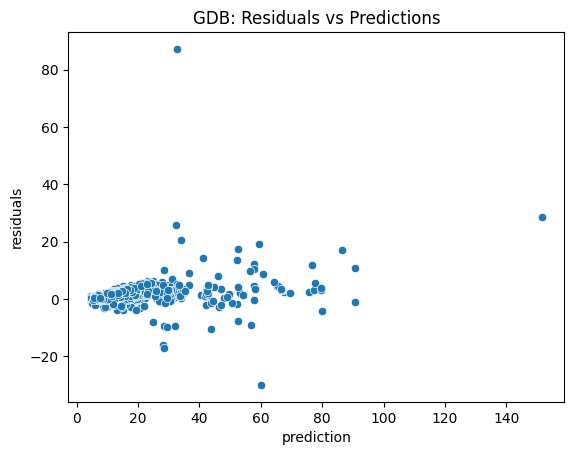

In [27]:
# Convert the residuals to a Pandas DataFrame for visualization
gdb_residuals_pandas = gdb_residuals.toPandas()

# Plot residuals vs predictions for the Gradient Boosting model
sns.scatterplot(x=gdb_residuals_pandas['prediction'], y=gdb_residuals_pandas['residuals'])
plt.title("GDB: Residuals vs Predictions")
plt.show()

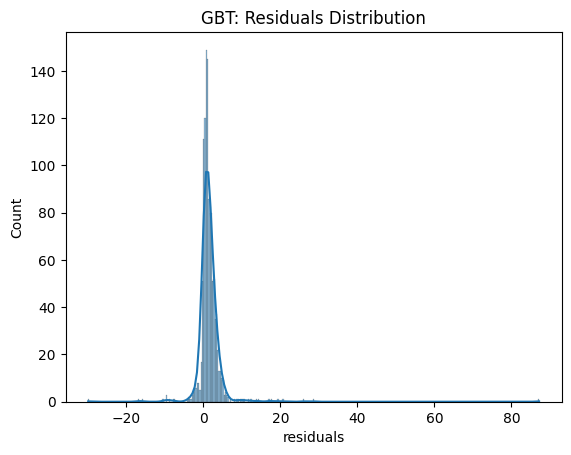

In [28]:
# Plot histogram of residuals for the Gradient Boosting model
sns.histplot(gdb_residuals_pandas['residuals'], kde=True)
plt.title("GBT: Residuals Distribution")
plt.show()

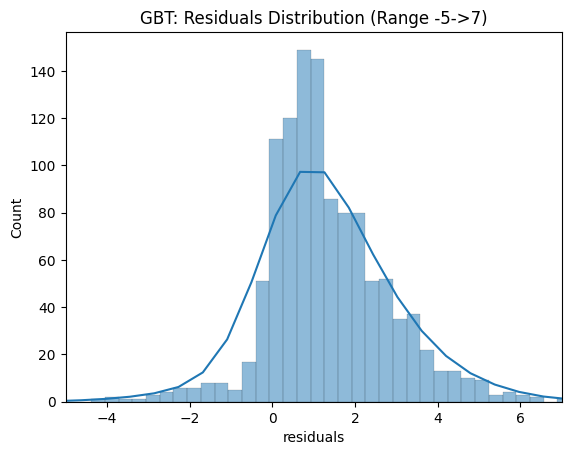

In [29]:
sns.histplot(gdb_residuals_pandas['residuals'], kde=True)
plt.title("GBT: Residuals Distribution (Range -5->7)")
plt.xlim(-5, 7)
plt.show()

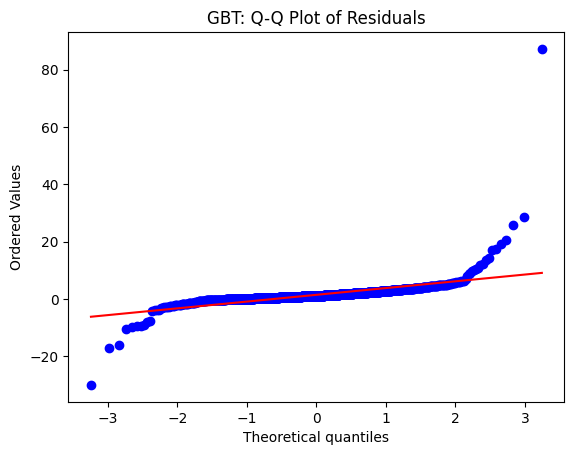

In [30]:
# Q-Q plot of residuals for the Gradient Boosting model to check normality
stats.probplot(gdb_residuals_pandas['residuals'], dist="norm", plot=plt)
plt.title("GBT: Q-Q Plot of Residuals")
plt.show()

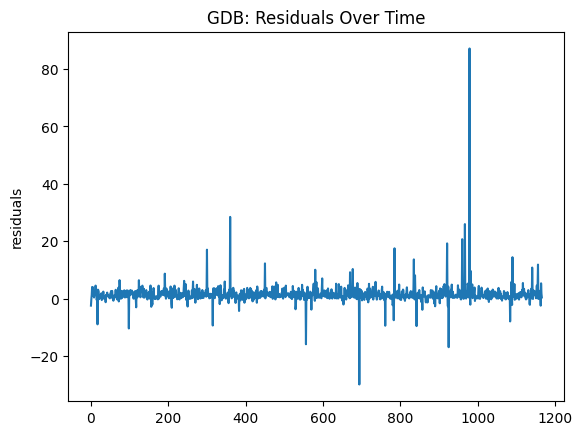

In [31]:
# Plot residuals over time for the Gradient Boosting model
sns.lineplot(x=range(len(gdb_residuals_pandas['residuals'])), y=gdb_residuals_pandas['residuals'])
plt.title("GDB: Residuals Over Time")
plt.show()

In [33]:
feature_importances = gdb_model.featureImportances
feature_names = relevant_columns
feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}

print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature Importances:
Feature: VendorID, Importance: 0.0006
Feature: trip_distance, Importance: 0.6909
Feature: RatecodeID, Importance: 0.0893
Feature: PULocationID, Importance: 0.0018
Feature: DOLocationID, Importance: 0.0265
Feature: extra, Importance: 0.0008
Feature: mta_tax, Importance: 0.0025
Feature: tolls_amount, Importance: 0.0083
Feature: improvement_surcharge, Importance: 0.0001
Feature: congestion_surcharge, Importance: 0.0019
Feature: airport_fee, Importance: 0.0004
Feature: trip_duration_mins, Importance: 0.1540
Feature: pickup_hour, Importance: 0.0062
Feature: pickup_dayofweek, Importance: 0.0002
Feature: dropoff_hour, Importance: 0.0024
Feature: dropoff_dayofweek, Importance: 0.0000
Feature: days_since_2022_11_01, Importance: 0.0008
Feature: distance_time_interaction, Importance: 0.0032
Feature: is_airport_trip, Importance: 0.0013
Feature: is_tourist_trip, Importance: 0.0000
Feature: pickup_at_airport, Importance: 0.0029
Feature: dropoff_at_airport, Importance: 0.0042
Fea

#### 1. Residuals vs. Predictions Plot
- **Observation**: The residuals vs. predictions plot shows a concentration of residuals near zero for lower predicted values, indicating good model performance in these cases. However, as predictions increase, residuals become more spread out, with some significant outliers.
- **Insight**: The GBDT model generally performs well for lower predictions but struggles with higher predictions, leading to underestimation (positive residuals) in some cases. The dispersion of residuals at higher values suggests that the model may not fully capture the complexity of the relationships at these levels.

#### 2. Residuals Distribution
- **Observation**: The histogram of residuals is sharply peaked around zero, indicating a strong concentration of accurate predictions. However, the distribution is right-skewed, with a tail extending toward larger positive residuals. However, pretty few predictions are recorded for the right-skewed tail.
- **Insight**: This skew suggests that while the GBDT model is generally accurate, it tends to underpredict for a portion of the data, leading to a higher occurrence of positive residuals. The sharp peak near zero highlights the model's overall effectiveness.
- **Observation**: When zooming in on a narrower range, the residual distribution appears more normal, centered around zero with a slight skew.
- **Insight**: Within this range, the model performs well, with a balanced distribution of residuals. The slight skew indicates some persistent underprediction, but the distribution suggests that most predictions are close to the actual values.

#### 3. Q-Q Plot of Residuals
- **Observation**: The Q-Q plot reveals deviations from the normal line, particularly at the extremes, where residuals are larger than expected under a normal distribution.
- **Insight**: The deviations in the Q-Q plot indicate that the residuals are not perfectly normally distributed, especially in the tails. This suggests that the GBDT model may struggle with extreme cases, leading to systematic errors in these situations.

#### 4. Residuals Over Time
- **Observation**: The residuals over time plot shows consistent residuals around zero, with occasional spikes indicating large errors.
- **Insight**: The consistency of residuals over time reflects the model's stable performance across the dataset. However, the spikes indicate specific instances where the model's predictions were significantly off, potentially due to changes in underlying data patterns or outliers that the model failed to capture.

### Feature Importance Analysis
- **Top Features**:
  - `trip_distance` (Importance: 0.6909): This feature is by far the most important predictor, indicating that the distance of the trip is the primary driver of the model's predictions.
  - `RatecodeID` (Importance: 0.0893) and `trip_duration_mins` (Importance: 0.1540): These features also contribute significantly, suggesting that different rate codes and trip durations play critical roles in determining the target variable.
  
- **Less Important Features**:
  - Many features such as `pickup_dayofweek`, `dropoff_dayofweek`, and `is_event_day` have minimal importance, suggesting they have little to no impact on the model's predictions.
  - **Insight**: The low importance of these features might indicate that the GBDT model captures the majority of the variance in the target variable through a few key features, while others add little incremental value.

=> **Model Performance**: The GBDT model performs well for the majority of cases, with residuals concentrated around zero. However, it exhibits weaknesses in handling higher prediction values and extreme cases, as shown by the spread in residuals and deviations in the Q-Q plot.

In [35]:
# Stop the Spark session to release resources
spark.stop()